In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def show_image_with_pyplot(img ,grayscale=True, ax=None):
    if grayscale:  img_plt = img
    else:          img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    if ax is None:
        fig = plt.figure(figsize=(14, 10))
        ax = plt.axes(xticks=[], yticks=[])
    
    if grayscale:  ax.imshow(img_plt, cmap='gray')
    else:               ax.imshow(img_plt)

In [0]:
# requires a grayscale image as input
def preprocessing(img):
    # create a CLAHE object for Histogram equalisation and improvng the contrast.
    img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(8,8))
    enhanced = clahe.apply(img_plt)

    # Edge preserving smoother: https://dsp.stackexchange.com/questions/60916/what-is-the-bilateral-filter-category-lpf-hpf-bpf-or-bsf
    blurred = cv2.GaussianBlur(enhanced, (7,7), 0)
    blurred = cv2.bilateralFilter(blurred,7,75,75)
    thresholded_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    inverted = cv2.bitwise_not(thresholded_img)
    return inverted

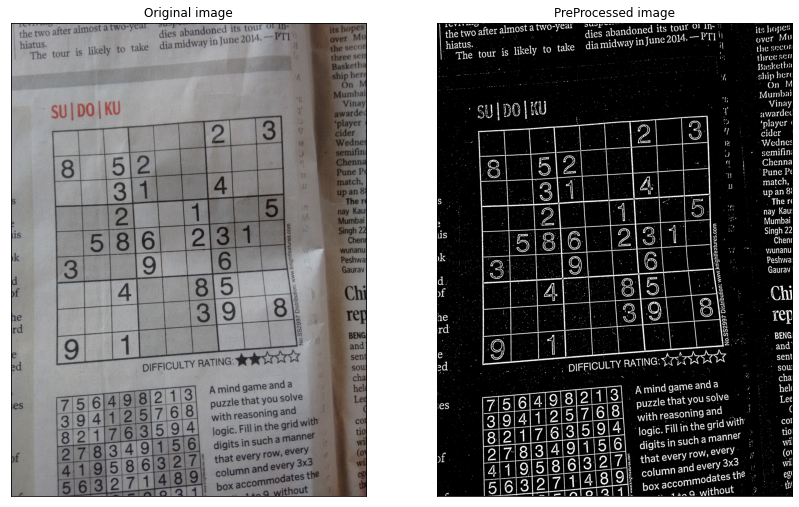

In [4]:
inp_img = cv2.imread("image2.jpg")
fig = plt.figure(figsize=(14, 14))

ax1 = plt.subplot(121)
ax1.set_title("Original image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_title("PreProcessed image")
ax2.set_xticks([])
ax2.set_yticks([])

ret_img = preprocessing(inp_img)
# ret_img = cv2.Canny(ret_img, 50, 200)
show_image_with_pyplot(inp_img, grayscale=False, ax=ax1)
show_image_with_pyplot(ret_img, grayscale=True, ax=ax2)

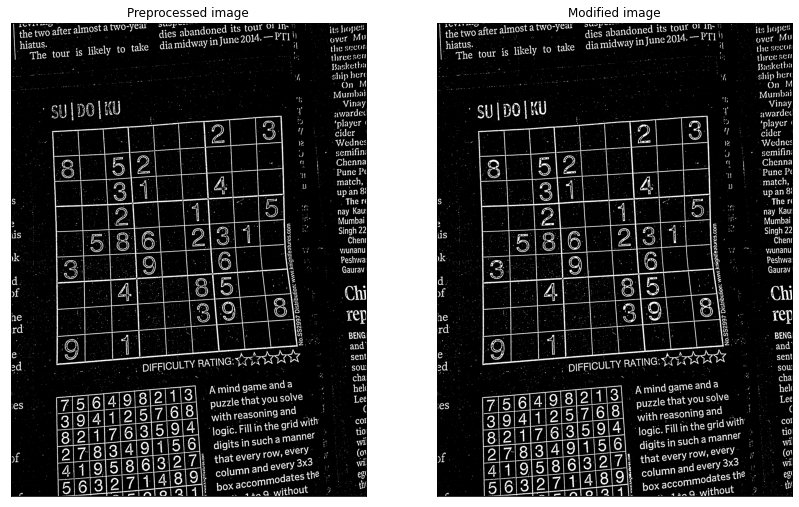

In [5]:
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi

def fill_gaps(img, iterations=2):
  # Reference: https://stackoverflow.com/questions/28078530/gap-filling-contours-lines
  for i in range(iterations):
    out = ndi.distance_transform_edt(~img)
    out = out < 0.01 * out.max()
    out = morphology.skeletonize(out)
    out = morphology.binary_closing(out, morphology.selem.disk(4))
    out = segmentation.clear_border(out)
    out = np.array(out*255, dtype=np.uint8)
    out = cv2.bitwise_or(np.uint8(out), img)
    img = out
  return out

refined_img = fill_gaps(ret_img, iterations=4)

fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot(121)
ax1.set_title("Preprocessed image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_title("Modified image")
ax2.set_xticks([])
ax2.set_yticks([])

show_image_with_pyplot(ret_img, grayscale=True, ax=ax1)
show_image_with_pyplot(refined_img, grayscale=True, ax=ax2)

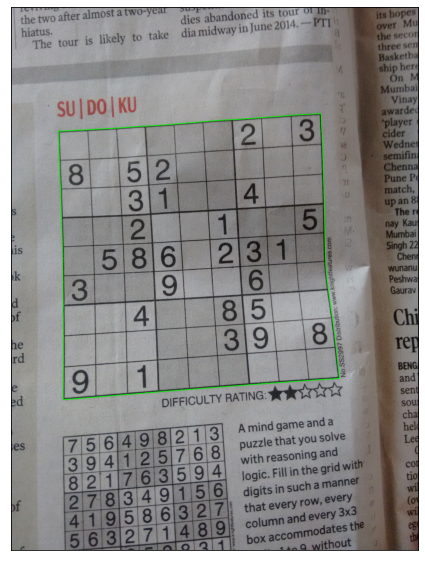

In [6]:
# find contours in the edged image, keep only the largest
contours, hierarchy = cv2.findContours(ret_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
grid_cnt = np.array(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
draw_cnt = inp_img.copy()
main_contour = grid_cnt[0]
cv2.drawContours(draw_cnt, [main_contour], -1, (0, 255, 0), 3)

show_image_with_pyplot(draw_cnt, grayscale=False)

(array([282, 752], dtype=int32), array([1860,  646], dtype=int32), array([1972, 2233], dtype=int32), array([ 313, 2362], dtype=int32))
(4, 1, 2) [[1860  646]] [[282 752]] [[ 313 2362]] [[1972 2233]]


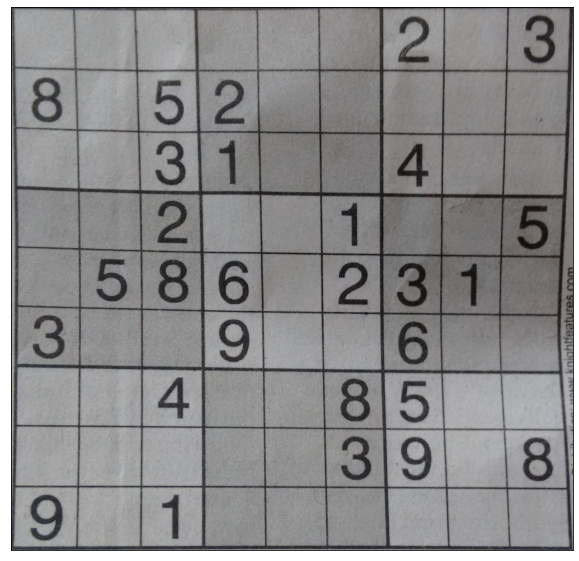

In [24]:
import operator
def perspective_transform(image, corners):
    # Reference: https://stackoverflow.com/questions/57636399/how-to-detect-sudoku-grid-board-in-opencv

    def order_corner_points(corners):
        # Bottom-right point has the largest (x + y) value
        # Top-left has point smallest (x + y) value
        # Bottom-left point has smallest (x - y) value
        # Top-right point has largest (x - y) value
        bottom_r, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        top_l, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        bottom_l, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        top_r, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        return (corners[top_l][0], corners[top_r][0], corners[bottom_r][0], corners[bottom_l][0])

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners
    print(ordered_corners)

    # Determine width of new image which is the max distance between 
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between 
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in 
    # top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                    [0, height - 1]], dtype = "float32")

    # Convert to Numpy format
    ordered_corners = np.array(ordered_corners, dtype="float32")

    # Find perspective transform matrix
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # Return the transformed image
    return cv2.warpPerspective(image, matrix, (width, height))

peri = cv2.arcLength(main_contour, True)
approx = cv2.approxPolyDP(main_contour, 0.01 * peri, True)
transformed = perspective_transform(inp_img, approx)
print(approx.shape, approx[0], approx[1], approx[2], approx[3])

show_image_with_pyplot(transformed, grayscale=False)